In [69]:
# Pacotes básicos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Pacotes para ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('max_columns',100)

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Rótulo verdadeiro')
    plt.xlabel('Predição')
    plt.grid(None)

# Os dados

Dados de pessoa que solicitaram cartão de crédito em um banco chinês.

In [71]:
dados = pd.read_csv('dados/base_ptbr2.csv')
print('Número de Observações: ',dados.shape[0])
dados.head(5)

Número de Observações:  36457


,SEXO,POSSUI_CARRO,POSSUI_IMOVEL,QTD_FILHOS,RENDA_ANUAL,TIPO_RENDA,ESCOLARIDADE,ESTADO_CIVIL,TIPO_MORADIA,DIAS_EMPREGADO,TAMANHO_FAMILIA,IDADE,ROTULO
0,M,Sim,Sim,0,427500.0,Trabalho,Graduação completa,Casado no civil,Apartamento alugado,4542,2.0,33.0,BOM
1,M,Sim,Sim,0,427500.0,Trabalho,Graduação completa,Casado no civil,Apartamento alugado,4542,2.0,33.0,BOM
2,M,Sim,Sim,0,112500.0,Trabalho,Licenciatura,Casado,Casa / Apartamento,1134,2.0,59.0,BOM
3,F,Não,Sim,0,270000.0,Representate comercial,Licenciatura,Solteiro,Casa / Apartamento,3051,1.0,52.0,BOM
4,F,Não,Sim,0,270000.0,Representate comercial,Licenciatura,Solteiro,Casa / Apartamento,3051,1.0,52.0,BOM


**Criação da Variável Resposta**  
0 = MAU  
1 = BOM

In [72]:
dados['VR'] = dados.ROTULO.map({'BOM':1, 'MAU':0})

### Quais problema queremos resolver?

> - **Reduzir prejuízos gerados por clientes inadimplentes no pagamento dos produtos de crédito.**  
> - **Quanto limite de crédito conceder para cada cliente, de forma personalizada?**

**Valores nulos**

In [73]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEXO             36457 non-null  object 
 1   POSSUI_CARRO     36457 non-null  object 
 2   POSSUI_IMOVEL    36457 non-null  object 
 3   QTD_FILHOS       36457 non-null  int64  
 4   RENDA_ANUAL      36457 non-null  float64
 5   TIPO_RENDA       36457 non-null  object 
 6   ESCOLARIDADE     36457 non-null  object 
 7   ESTADO_CIVIL     36457 non-null  object 
 8   TIPO_MORADIA     36457 non-null  object 
 9   DIAS_EMPREGADO   36457 non-null  int64  
 10  TAMANHO_FAMILIA  36457 non-null  float64
 11  IDADE            36457 non-null  float64
 12  ROTULO           36457 non-null  object 
 13  VR               36457 non-null  int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 3.9+ MB


# Análise Exploratória

**Distribuição de BONS e MAUS na Base**

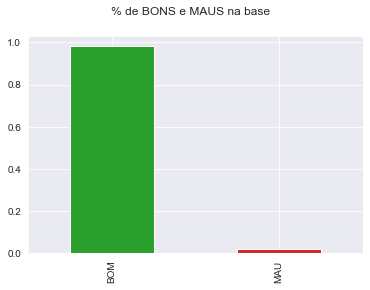

In [74]:
plt.suptitle('% de BONS e MAUS na base')
dados.ROTULO.value_counts(normalize=True).plot.bar(color=['tab:green','tab:red'])

Temos poucos MAUS na base então será necessário fazer uma superamostragem na base para dar mais insumo ao modelo.

In [75]:
# Limpeza
dados.loc[dados.DIAS_EMPREGADO<0, 'DIAS_EMPREGADO'] = 0

## Análise Univariada

### Distribuições

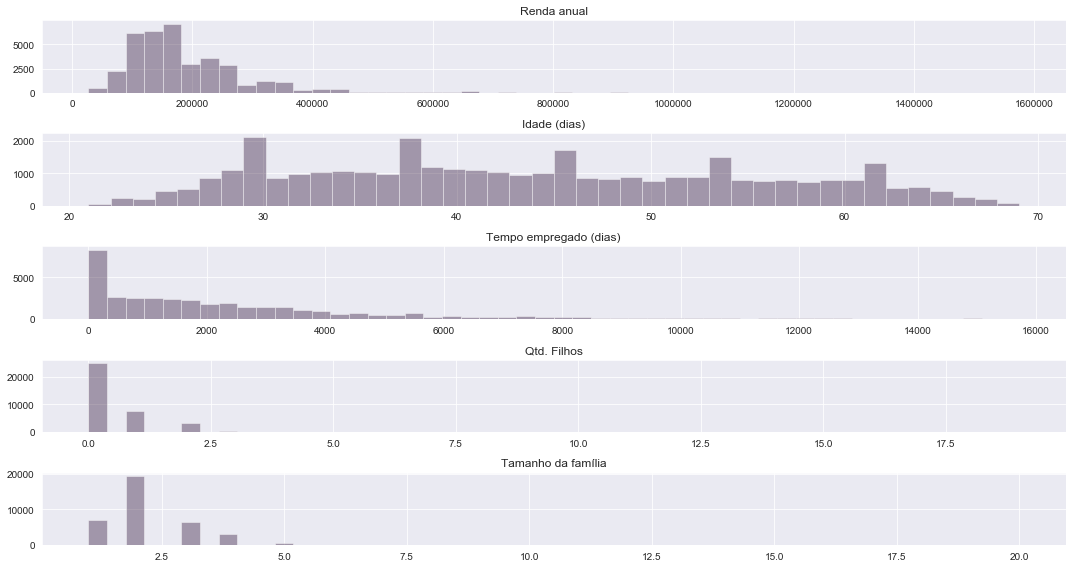

In [76]:
fig, ax = plt.subplots(5,1, figsize=(15,8))
sns.distplot(ax=ax[0], a=dados.RENDA_ANUAL, kde=False)
sns.distplot(ax=ax[1], a=dados.IDADE, kde=False)
sns.distplot(ax=ax[2], a=dados.DIAS_EMPREGADO, kde=False)
sns.distplot(ax=ax[3], a=dados.QTD_FILHOS, kde=False)
sns.distplot(ax=ax[4], a=dados.TAMANHO_FAMILIA, kde=False)
ax[0].set(title='Renda anual', xlabel='')
ax[1].set(title='Idade (dias)', xlabel='')
ax[2].set(title='Tempo empregado (dias)', xlabel='')
ax[3].set(title='Qtd. Filhos', xlabel='')
ax[4].set(title='Tamanho da família', xlabel='')
plt.tight_layout()

### Distribuição em relação a Variável Resposta

[Text(0.5, 0, ''), Text(0.5, 1.0, 'Tamanho da família')]

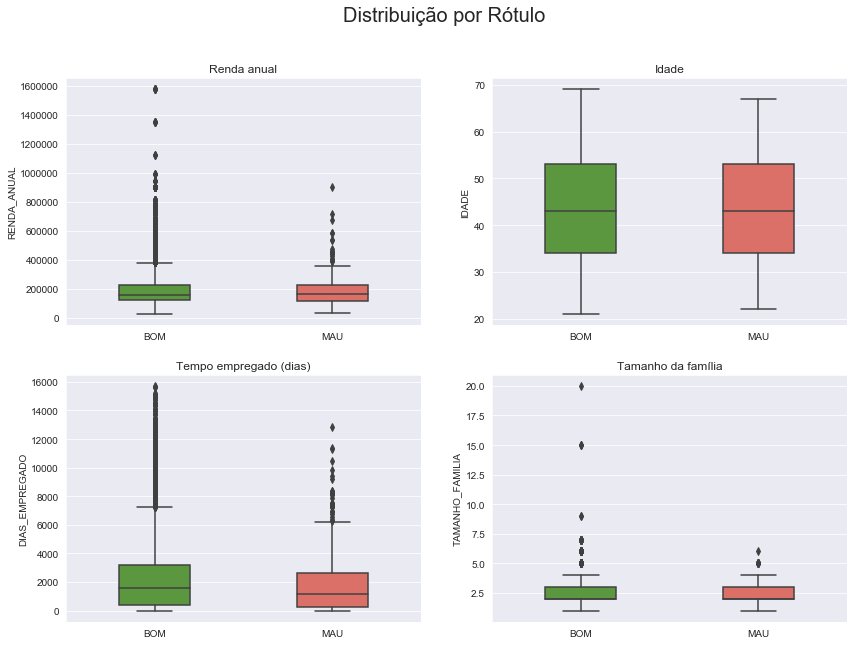

In [77]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
fig.suptitle('Distribuição por Rótulo', size=20)
sns.boxplot(ax=ax[0,0], y=dados.RENDA_ANUAL, x=dados.ROTULO, palette=sns.color_palette(['#55a630','#ee6055']), width=0.4)
sns.boxplot(ax=ax[0,1], y=dados.IDADE, x=dados.ROTULO, palette=sns.color_palette(['#55a630','#ee6055']), width=0.4)
sns.boxplot(ax=ax[1,0], y=dados.DIAS_EMPREGADO, x=dados.ROTULO, palette=sns.color_palette(['#55a630','#ee6055']), width=0.4)
sns.boxplot(ax=ax[1,1], y=dados.TAMANHO_FAMILIA, x=dados.ROTULO, palette=sns.color_palette(['#55a630','#ee6055']), width=0.4)
ax[0,0].set(title='Renda anual', xlabel='')
ax[0,1].set(title='Idade', xlabel='')
ax[1,0].set(title='Tempo empregado (dias)', xlabel='')
ax[1,1].set(title='Tamanho da família', xlabel='')

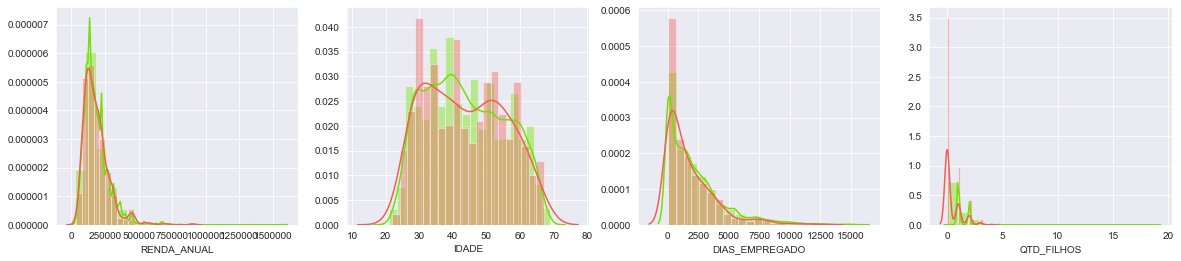

In [78]:
fig, ax = plt.subplots(1,4, figsize=(20,4))
sns.distplot(ax=ax[0], a=dados.loc[dados.ROTULO=='BOM','RENDA_ANUAL'], bins=20, label='BOM', color='#70e000')
sns.distplot(ax=ax[0], a=dados.loc[dados.ROTULO=='MAU','RENDA_ANUAL'], bins=20, label='MAU', color='#ee6055')

sns.distplot(ax=ax[1], a=dados.loc[dados.ROTULO=='BOM','IDADE'], bins=20, label='BOM', color='#70e000')
sns.distplot(ax=ax[1], a=dados.loc[dados.ROTULO=='MAU','IDADE'], bins=20, label='MAU', color='#ee6055')

sns.distplot(ax=ax[2], a=dados.loc[dados.ROTULO=='BOM','DIAS_EMPREGADO'], bins=20, label='BOM', color='#70e000')
sns.distplot(ax=ax[2], a=dados.loc[dados.ROTULO=='MAU','DIAS_EMPREGADO'], bins=20, label='MAU', color='#ee6055')

sns.distplot(ax=ax[3], a=dados.loc[dados.ROTULO=='BOM','QTD_FILHOS'], bins=20, label='BOM', color='#70e000')
sns.distplot(ax=ax[3], a=dados.loc[dados.ROTULO=='MAU','QTD_FILHOS'], bins=20, label='MAU', color='#ee6055')

## Variáveis categóricas

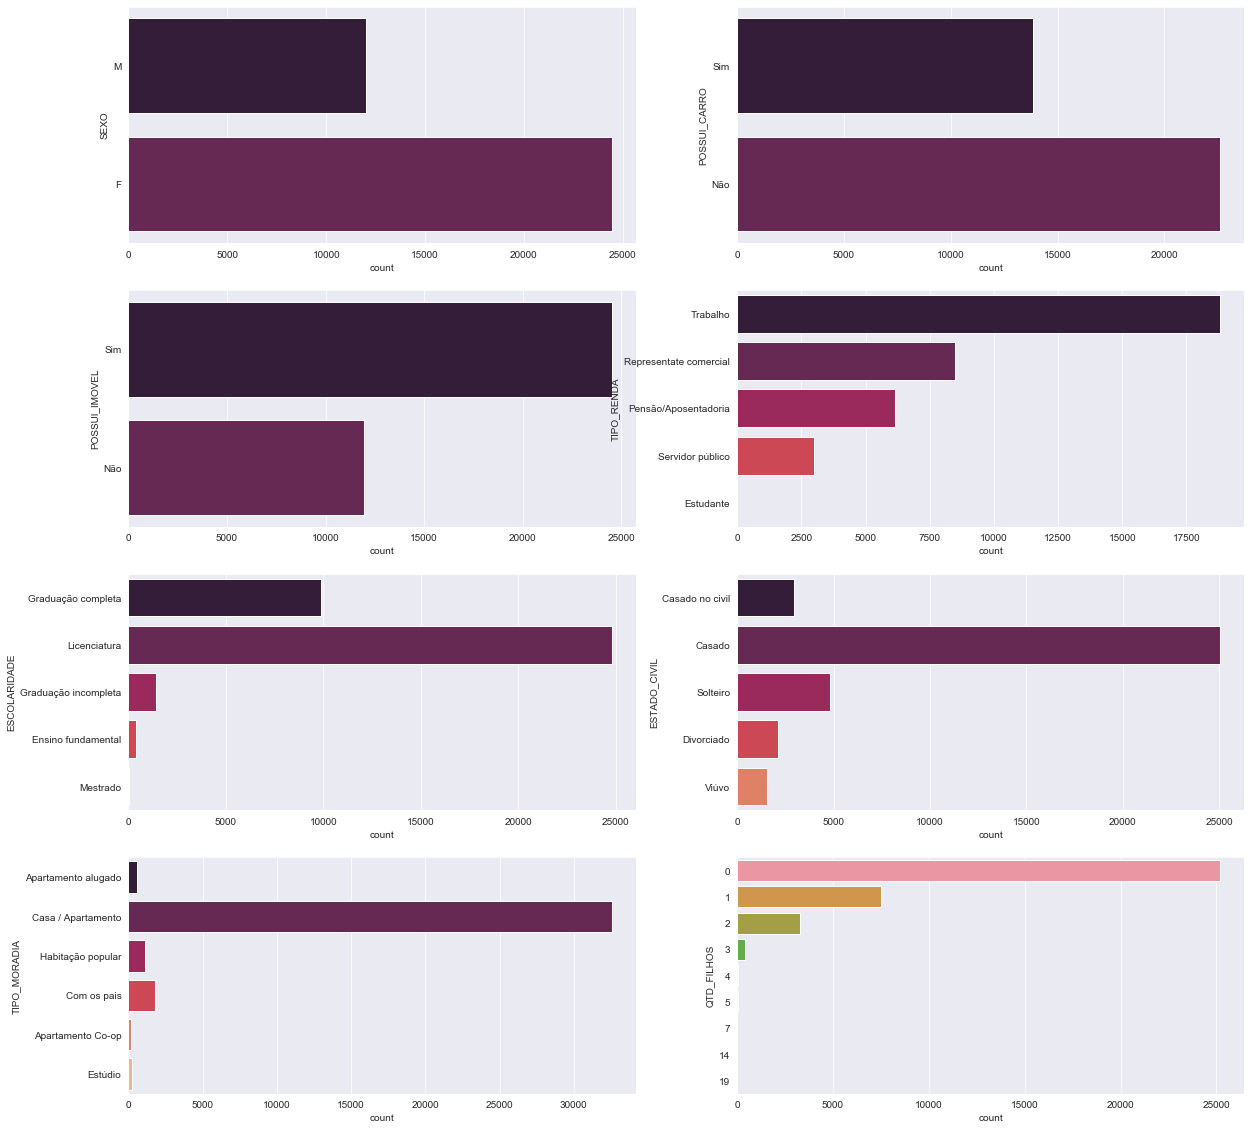

In [79]:
sns.set_palette('rocket')
fig, ax = plt.subplots(4,2, figsize=(20,20))

sns.countplot(ax=ax[0,0], y=dados['SEXO'])
sns.countplot(ax=ax[0,1], y=dados['POSSUI_CARRO'])
sns.countplot(ax=ax[1,0], y=dados['POSSUI_IMOVEL'])
sns.countplot(ax=ax[1,1], y=dados['TIPO_RENDA'])
sns.countplot(ax=ax[2,0], y=dados['ESCOLARIDADE'])
sns.countplot(ax=ax[2,1], y=dados['ESTADO_CIVIL'])
sns.countplot(ax=ax[3,0], y=dados['TIPO_MORADIA'])
sns.countplot(ax=ax[3,1], y=dados['QTD_FILHOS'])

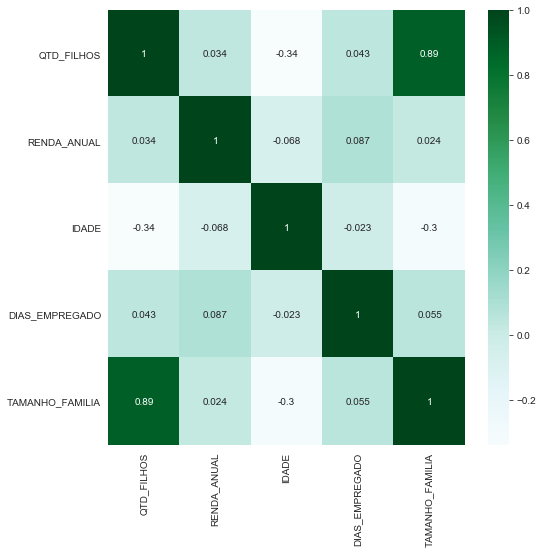

In [80]:
plt.figure(figsize=(8,8))
sns.heatmap(data=dados[['QTD_FILHOS','RENDA_ANUAL','IDADE','DIAS_EMPREGADO','TAMANHO_FAMILIA']].corr(), annot=True, cmap='BuGn')

In [81]:
# Criando cópia da base original
df_treino = dados.drop('ROTULO', axis=1).copy()

# Peso da Evidência & Information Value (WoE & IV)

![Tabela IV](Imagens/tb_referencia_iv.png)

In [82]:
#Funçao para cálculo de WoE e IV
def woe_iv(dados, variavel, variavel_resposta):
    df_woe = pd.crosstab(index=dados[variavel], columns=dados[variavel_resposta])
    df_woe['Total'] = df_woe[0] + df_woe[1]
    df_woe['% Bom'] = df_woe[1] / df_woe[1].sum()
    df_woe['% Mau'] = df_woe[0]/ df_woe[0].sum()
    df_woe['WoE'] = np.log(df_woe['% Bom'] / df_woe['% Mau'])
    df_woe['IV'] = (df_woe['% Bom'] - df_woe['% Mau']) * df_woe['WoE']
    df_woe = df_woe.rename(columns={0:'Maus', 1:'Bons'})
    print('IV: ', df_woe.loc[df_woe.WoE!=np.inf, 'IV'].sum())
    display(df_woe.sort_index())
    # return df_woe, df_woe['IV'].sum() 

**SEXO**

In [83]:
woe_iv(df_treino, 'SEXO', 'VR')

IV:  0.013581371667358226


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
SEXO,,,,,,,
F,379,24051,24430,0.671047,0.61526,0.086795,0.004842
M,237,11790,12027,0.328953,0.38474,-0.156654,0.008739


<img src="Imagens/dislike.png" width=60ox>

**POSSUI_CARRO**

In [84]:
woe_iv(df_treino, 'POSSUI_CARRO', 'VR')

IV:  0.0011443033795676962


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
POSSUI_CARRO,,,,,,,
Não,392,22222,22614,0.620016,0.636364,-0.026025,0.000425
Sim,224,13619,13843,0.379984,0.363636,0.043974,0.000719


<img src="Imagens/dislike.png" width=60ox>

**POSSUI_IMOVEL**

In [85]:
woe_iv(df_treino, 'POSSUI_IMOVEL', 'VR')

IV:  0.028349157710111452


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
POSSUI_IMOVEL,,,,,,,
Não,251,11700,11951,0.326442,0.407468,-0.221710,0.017964
Sim,365,24141,24506,0.673558,0.592532,0.128169,0.010385


<img src="Imagens/good.png" width=60ox>

**QTD_FILHOS**

In [86]:
woe_iv(df_treino, 'QTD_FILHOS', 'VR')

IV:  0.005373999418640605


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
QTD_FILHOS,,,,,,,
0,431,24770,25201,0.691108,0.699675,-0.012320,0.000106
1,120,7372,7492,0.205686,0.194805,0.054352,0.000591
2,52,3204,3256,0.089395,0.084416,0.057311,0.000285
3,12,407,419,0.011356,0.019481,-0.539694,0.004385
4,1,62,63,0.001730,0.001623,0.063534,0.000007
5,0,20,20,0.000558,0.000000,inf,inf
7,0,2,2,0.000056,0.000000,inf,inf
14,0,3,3,0.000084,0.000000,inf,inf
19,0,1,1,0.000028,0.000000,inf,inf


<img src="Imagens/dislike.png" width=60ox>

**TAMANHO_FAMILIA**

In [87]:
woe_iv(df_treino, 'TAMANHO_FAMILIA', 'VR')

IV:  0.013897094218452762


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
TAMANHO_FAMILIA,,,,,,,
1.0,139,6848,6987,0.191066,0.225649,-0.166363,5.753368e-03
2.0,313,19150,19463,0.534304,0.508117,0.050254,1.316022e-03
3.0,105,6316,6421,0.176223,0.170455,0.033280,1.919675e-04
4.0,46,3060,3106,0.085377,0.074675,0.133928,1.433265e-03
5.0,12,385,397,0.010742,0.019481,-0.595264,5.201794e-03
6.0,1,57,58,0.001590,0.001623,-0.020550,6.785295e-07
7.0,0,19,19,0.000530,0.000000,inf,inf
9.0,0,2,2,0.000056,0.000000,inf,inf
15.0,0,3,3,0.000084,0.000000,inf,inf


> **Feature Engineering**

In [88]:
df_treino['TAMANHO_FAMILIA_2'] = pd.cut(df_treino['TAMANHO_FAMILIA'], bins=[-1,0,1,3,100], include_lowest=True)
woe_iv(df_treino, 'TAMANHO_FAMILIA_2', 'VR')

IV:  0.007294994026498985


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
TAMANHO_FAMILIA_2,,,,,,,
"(0.0, 1.0]",139,6848,6987,0.191066,0.225649,-0.166363,0.005753
"(1.0, 3.0]",418,25466,25884,0.710527,0.678571,0.046017,0.001471
"(3.0, 100.0]",59,3527,3586,0.098407,0.095779,0.027065,0.000071


**Criação de nova coluna:** FL_SEM_FAMILIA

In [89]:
df_treino['FL_SEM_FAMILIA'] = [1 if val==1 else 0 for val in df_treino['TAMANHO_FAMILIA']]
woe_iv(df_treino, 'FL_SEM_FAMILIA', 'VR')

IV:  0.0072643930224413076


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
FL_SEM_FAMILIA,,,,,,,
0,477,28993,29470,0.808934,0.774351,0.043692,0.001511
1,139,6848,6987,0.191066,0.225649,-0.166363,0.005753


<img src="Imagens/dislike.png" width=60ox>

**TIPO_RENDA**

In [90]:
woe_iv(df_treino, 'TIPO_RENDA', 'VR')

IV:  0.017556100491037264


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
TIPO_RENDA,,,,,,,
Estudante,0,11,11,0.000307,0.000000,inf,inf
Pensão/Aposentadoria,130,6022,6152,0.168020,0.211039,-0.227961,0.009807
Representate comercial,143,8347,8490,0.232890,0.232143,0.003212,0.000002
Servidor público,37,2948,2985,0.082252,0.060065,0.314364,0.006975
Trabalho,306,18513,18819,0.516531,0.496753,0.039043,0.000772


> **Feature Engineering**

In [91]:
df_treino['TIPO_RENDA_2'] = df_treino['TIPO_RENDA'].replace({'Estudante':'Estudante/Trabalho/Representante Com.',
                                                            'Trabalho':'Estudante/Trabalho/Representante Com.',
                                                            'Representate comercial':'Estudante/Trabalho/Representante Com.'})

In [92]:
woe_iv(df_treino, 'TIPO_RENDA_2', 'VR')

IV:  0.01736853961698635


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
TIPO_RENDA_2,,,,,,,
Estudante/Trabalho/Representante Com.,449,26871,27320,0.749728,0.728896,0.028179,0.000587
Pensão/Aposentadoria,130,6022,6152,0.168020,0.211039,-0.227961,0.009807
Servidor público,37,2948,2985,0.082252,0.060065,0.314364,0.006975


<img src="Imagens/good.png" width=60ox>

**ESCOLARIDADE**

In [93]:
woe_iv(df_treino, 'ESCOLARIDADE', 'VR')

IV:  0.009208778787924534


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
ESCOLARIDADE,,,,,,,
Ensino fundamental,10,364,374,0.010156,0.016234,-0.469032,0.002851
Graduação completa,171,9693,9864,0.270444,0.277597,-0.026105,0.000187
Graduação incompleta,33,1377,1410,0.038420,0.053571,-0.332446,0.005037
Licenciatura,402,24375,24777,0.680087,0.652597,0.041260,0.001134
Mestrado,0,32,32,0.000893,0.000000,inf,inf


> **Feature Engineering**

In [94]:
df_treino['ESCOLARIDADE_2'] = df_treino['ESCOLARIDADE'].replace({'Licenciatura':'Superior completo',
                                                                'Mestrado':'Superior completo',
                                                                'Graduação completa':'Superior completo',
                                                                'Ensino fundamental':'Superior incompleto',
                                                                'Graduação incompleta':'Superior incompleto'})

In [95]:
woe_iv(df_treino, 'ESCOLARIDADE_2', 'VR')

IV:  0.008176602861786564


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
ESCOLARIDADE_2,,,,,,,
Superior completo,573,34100,34673,0.951424,0.930195,0.022566,0.000479
Superior incompleto,43,1741,1784,0.048576,0.069805,-0.362586,0.007698


<img src="Imagens/good.png" width=60ox>

**ESTADO_CIVIL**

In [96]:
woe_iv(df_treino, 'ESTADO_CIVIL', 'VR')

IV:  0.030119259773091364


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
ESTADO_CIVIL,,,,,,,
Casado,393,24655,25048,0.687899,0.637987,0.075325,0.003760
Casado no civil,46,2899,2945,0.080885,0.074675,0.079879,0.000496
Divorciado,31,2072,2103,0.057811,0.050325,0.138682,0.001038
Solteiro,101,4728,4829,0.131916,0.163961,-0.217464,0.006969
Viúvo,45,1487,1532,0.041489,0.073052,-0.565747,0.017857


> **Feature Engineering**

In [97]:
df_treino['ESTADO_CIVIL_2'] = df_treino['ESTADO_CIVIL'].replace({'Casado no civil':'Casado/Separado',
                                                                'Casado':'Casado/Separado',
                                                                'Divorciado':'Casado/Separado'})

In [98]:
woe_iv(df_treino, 'ESTADO_CIVIL_2', 'VR')

IV:  0.029918785232359604


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
ESTADO_CIVIL_2,,,,,,,
Casado/Separado,470,29626,30096,0.826595,0.762987,0.080074,0.005093
Solteiro,101,4728,4829,0.131916,0.163961,-0.217464,0.006969
Viúvo,45,1487,1532,0.041489,0.073052,-0.565747,0.017857


<img src="Imagens/good.png" width=60ox>

**TIPO_MORADIA**

In [99]:
woe_iv(df_treino, 'TIPO_MORADIA', 'VR')

IV:  0.015711059499443562


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
TIPO_MORADIA,,,,,,,
Apartamento Co-op,3,165,168,0.004604,0.004870,-0.056268,0.000015
Apartamento alugado,8,567,575,0.015820,0.012987,0.197317,0.000559
Casa / Apartamento,540,32008,32548,0.893055,0.876623,0.018571,0.000305
Com os pais,26,1750,1776,0.048827,0.042208,0.145674,0.000964
Estúdio,9,253,262,0.007059,0.014610,-0.727436,0.005493
Habitação popular,30,1098,1128,0.030635,0.048701,-0.463553,0.008375


> **Feature Engineering**

In [100]:
df_treino['TIPO_MORADIA_2'] = df_treino['TIPO_MORADIA'].replace({'Apartamento Co-op':'Apartamento Co-op/Casa/Apartamento',
                                                            'Casa / Apartamento':'Apartamento Co-op/Casa/Apartamento',
                                                            'Com os pais':'Com os pais/Apartamento alugado',
                                                            'Apartamento alugado':'Com os pais/Apartamento alugado',
                                                            'Estúdio':'Estúdio/Habitação popular',
                                                            'Habitação popular':'Estúdio/Habitação popular'
                                                            })

In [101]:
woe_iv(df_treino, 'TIPO_MORADIA_2', 'VR')

IV:  0.01507202470535343


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
TIPO_MORADIA_2,,,,,,,
Apartamento Co-op/Casa/Apartamento,543,32173,32716,0.897659,0.881494,0.018173,0.000294
Com os pais/Apartamento alugado,34,2317,2351,0.064647,0.055195,0.158067,0.001494
Estúdio/Habitação popular,39,1351,1390,0.037694,0.063312,-0.518562,0.013284


<img src="Imagens/good.png" width=60px>

**RENDA_ANUAL**

In [102]:
# Definição de 5 faixas
df_treino['FX_RENDA'] = pd.qcut(df_treino['RENDA_ANUAL'], q=4)
woe_iv(df_treino, 'FX_RENDA', 'VR')

IV:  0.005200885141117309


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
FX_RENDA,,,,,,,
"(26999.999, 121500.0]",167,9226,9393,0.257415,0.271104,-0.051814,0.000709
"(121500.0, 157500.0]",139,9031,9170,0.251974,0.225649,0.110344,0.002905
"(157500.0, 225000.0]",183,9942,10125,0.277392,0.297078,-0.068563,0.001350
"(225000.0, 1575000.0]",127,7642,7769,0.213219,0.206169,0.033627,0.000237


<img src="Imagens/dislike.png" width=60ox>

**IDADE**

In [103]:
df_treino['FX_IDADE'] = pd.qcut(df_treino['IDADE'], q=4)
woe_iv(df_treino, 'FX_IDADE', 'VR')

IV:  0.008610560123773604


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
FX_IDADE,,,,,,,
"(20.999, 34.0]",177,9315,9492,0.259898,0.287338,-0.100369,0.002754
"(34.0, 43.0]",139,9372,9511,0.261488,0.225649,0.147407,0.005283
"(43.0, 53.0]",151,8379,8530,0.233783,0.245130,-0.047397,0.000538
"(53.0, 69.0]",149,8775,8924,0.244831,0.241883,0.012115,0.000036


<img src="Imagens/dislike.png" width=60ox>

**DIAS_EMPREGADO**

In [104]:
df_treino['FX_DIAS_EMP'] = pd.qcut(df_treino['DIAS_EMPREGADO'], q=5)
woe_iv(df_treino, 'FX_DIAS_EMP', 'VR')

IV:  0.03915948070913698


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
FX_DIAS_EMP,,,,,,,
"(-0.001, 200.0]",149,7154,7303,0.199604,0.241883,-0.192120,0.008123
"(200.0, 1081.0]",154,7158,7312,0.199715,0.250000,-0.224568,0.011292
"(1081.0, 2080.0]",105,7156,7261,0.199660,0.170455,0.158145,0.004619
"(2080.0, 3596.0]",115,7179,7294,0.200301,0.186688,0.070382,0.000958
"(3596.0, 15713.0]",93,7194,7287,0.200720,0.150974,0.284802,0.014168


> **Feature Engineering**

In [105]:
df_treino['FX_DIAS_EMP'] = pd.cut(df_treino['DIAS_EMPREGADO'], bins=[0,1081,3596,15713])
woe_iv(df_treino, 'FX_DIAS_EMP', 'VR')

IV:  0.04966455054574242


VR,Maus,Bons,Total,% Bom,% Mau,WoE,IV
FX_DIAS_EMP,,,,,,,
"(0, 1081]",190,8290,8480,0.278011,0.377734,-0.306530,0.030568
"(1081, 3596]",220,14335,14555,0.480734,0.437376,0.094521,0.004098
"(3596, 15713]",93,7194,7287,0.241256,0.184891,0.266092,0.014998


<img src="Imagens/good.png" width=60ox>

---

# Modelagem

<img src="Imagens/good.png" width=30px> **Variáveis Selecionas**
- POSSUI_IMOVEL
- TIPO_RENDA_2
- ESCOLARIDADE_2
- ESTADO_CIVIL_2
- TIPO_MORADIA_2
- FX_DIAS_EMPREGADO

<img src="Imagens/dislike.png" width=30px> **Variáveis eliminadas**
- SEXO - Fraca / Não recomendada
- POSSUI_CARRO - Fraca
- RENDA_ANUAL - Fraca
- DIAS_IDADE - Fraca
- QTD_FILHOS - Alta correlação com TAMANHO_FAMILIA
- TAMANHO_FAMILIA - Fraca

In [106]:
# Variveis selecionas
select = ['POSSUI_IMOVEL','FL_SEM_FAMILIA','TIPO_RENDA_2','ESCOLARIDADE_2','ESTADO_CIVIL_2','TIPO_MORADIA_2','FX_DIAS_EMP','VR']

In [107]:
df_select = df_treino[select].copy()

In [108]:
df_select.head()

,POSSUI_IMOVEL,FL_SEM_FAMILIA,TIPO_RENDA_2,ESCOLARIDADE_2,ESTADO_CIVIL_2,TIPO_MORADIA_2,FX_DIAS_EMP,VR
0,Sim,0,Estudante/Trabalho/Representante Com.,Superior completo,Casado/Separado,Com os pais/Apartamento alugado,"(3596, 15713]",1
1,Sim,0,Estudante/Trabalho/Representante Com.,Superior completo,Casado/Separado,Com os pais/Apartamento alugado,"(3596, 15713]",1
2,Sim,0,Estudante/Trabalho/Representante Com.,Superior completo,Casado/Separado,Apartamento Co-op/Casa/Apartamento,"(1081, 3596]",1
3,Sim,1,Estudante/Trabalho/Representante Com.,Superior completo,Solteiro,Apartamento Co-op/Casa/Apartamento,"(1081, 3596]",1
4,Sim,1,Estudante/Trabalho/Representante Com.,Superior completo,Solteiro,Apartamento Co-op/Casa/Apartamento,"(1081, 3596]",1


## Preparação da base

**Encoding**

In [109]:
df_select.POSSUI_IMOVEL = df_select.POSSUI_IMOVEL.replace({'Não':0, 'Sim':1})

**Dummies**

In [110]:
df_select = pd.get_dummies(df_select, columns=['TIPO_RENDA_2','ESCOLARIDADE_2','ESTADO_CIVIL_2','TIPO_MORADIA_2','FX_DIAS_EMP'], drop_first=True)
df_select.head()

,POSSUI_IMOVEL,FL_SEM_FAMILIA,VR,TIPO_RENDA_2_Pensão/Aposentadoria,TIPO_RENDA_2_Servidor público,ESCOLARIDADE_2_Superior incompleto,ESTADO_CIVIL_2_Solteiro,ESTADO_CIVIL_2_Viúvo,TIPO_MORADIA_2_Com os pais/Apartamento alugado,TIPO_MORADIA_2_Estúdio/Habitação popular,"FX_DIAS_EMP_(1081, 3596]","FX_DIAS_EMP_(3596, 15713]"
0,1,0,1,0,0,0,0,0,1,0,0,1
1,1,0,1,0,0,0,0,0,1,0,0,1
2,1,0,1,0,0,0,0,0,0,0,1,0
3,1,1,1,0,0,0,1,0,0,0,1,0
4,1,1,1,0,0,0,1,0,0,0,1,0


### Seperação de Treino e Validação(teste)

In [111]:
X = df_select.drop('VR', axis=1)
y = df_select['VR']

**Método:** Synthetic Minority Over-sampling

In [112]:
y = y.astype('int')
X_balanceado, y_balanceado = SMOTE(sampling_strategy='minority').fit_resample(X,y)
X_balanceado = pd.DataFrame(X_balanceado, columns = X.columns)

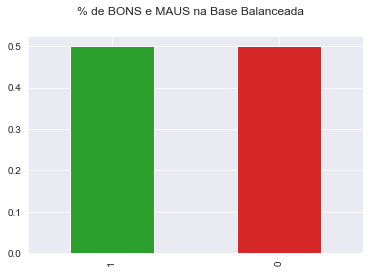

In [113]:
plt.suptitle('% de BONS e MAUS na Base Balanceada')
y_balanceado.value_counts(normalize=True).plot.bar(color=['tab:green','tab:red'])

**Splits**

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado, test_size=0.3, random_state=42)

---

## Regressão Logística

In [115]:
reglog = LogisticRegression(random_state=42, solver='lbfgs')

In [116]:
reglog.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [117]:
previsoes_treino = reglog.predict(X_train)
previsoes_validacao = reglog.predict(X_test)
reglog_roc = pd.DataFrame({'VR':y_test,'PROB':reglog.predict_proba(X_test)[:,1]})

In [118]:
print('Acurácia do treino: ',accuracy_score(y_train, previsoes_treino))
print('Acurácia de validação: ',accuracy_score(y_test, previsoes_validacao))

Acurácia do treino:  0.5588018414811567
Acurácia de validação:  0.5600093001627529


In [119]:
print('Resultados - Split de Validação')
print(classification_report(y_test, previsoes_validacao, target_names=['MAUS','BONS']))

Resultados - Split de Validação
              precision    recall  f1-score   support

        MAUS       0.55      0.63      0.59     10702
        BONS       0.57      0.49      0.53     10803

    accuracy                           0.56     21505
   macro avg       0.56      0.56      0.56     21505
weighted avg       0.56      0.56      0.56     21505



[[0.62735937 0.37264063]
 [0.5067111  0.4932889 ]]


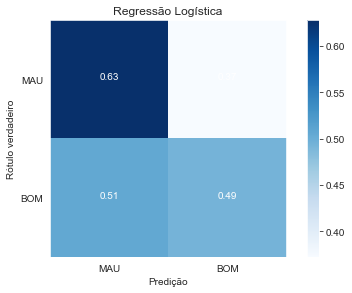

In [120]:
plot_confusion_matrix(confusion_matrix(y_test, previsoes_validacao),
                      classes=['MAU','BOM'] ,normalize = True, 
                      title='Regressão Logística')

## Árvore de Decisão

In [121]:
vars = ['SEXO', 'POSSUI_CARRO', 'POSSUI_IMOVEL', 'QTD_FILHOS', 'RENDA_ANUAL',
       'DIAS_EMPREGADO', 'TAMANHO_FAMILIA', 'IDADE', 'FL_SEM_FAMILIA', 'TIPO_RENDA_2', 'ESCOLARIDADE_2', 'ESTADO_CIVIL_2',
       'TIPO_MORADIA_2','VR']
df_tree = df_treino[vars].copy()

In [122]:
# Encoding
df_tree.POSSUI_CARRO = df_tree.POSSUI_CARRO.map({'Não':0, 'Sim':1})
df_tree.POSSUI_IMOVEL = df_tree.POSSUI_IMOVEL.map({'Não':0, 'Sim':1})
df_tree.SEXO = df_tree.SEXO.map({'M':0, 'F':1})

In [123]:
# Dummies
df_tree = pd.get_dummies(df_tree, columns=['TIPO_RENDA_2','ESCOLARIDADE_2','ESTADO_CIVIL_2','TIPO_MORADIA_2'], drop_first=True)

In [124]:
df_tree.head(3)

,SEXO,POSSUI_CARRO,POSSUI_IMOVEL,QTD_FILHOS,RENDA_ANUAL,DIAS_EMPREGADO,TAMANHO_FAMILIA,IDADE,FL_SEM_FAMILIA,VR,TIPO_RENDA_2_Pensão/Aposentadoria,TIPO_RENDA_2_Servidor público,ESCOLARIDADE_2_Superior incompleto,ESTADO_CIVIL_2_Solteiro,ESTADO_CIVIL_2_Viúvo,TIPO_MORADIA_2_Com os pais/Apartamento alugado,TIPO_MORADIA_2_Estúdio/Habitação popular
0,0,1,1,0,427500.0,4542,2.0,33.0,0,1,0,0,0,0,0,1,0
1,0,1,1,0,427500.0,4542,2.0,33.0,0,1,0,0,0,0,0,1,0
2,0,1,1,0,112500.0,1134,2.0,59.0,0,1,0,0,0,0,0,0,0


In [125]:
X = df_tree.drop('VR',axis=1)
y = df_tree['VR']
y = y.astype('int')
X_balanceado, y_balanceado = SMOTE(sampling_strategy='minority').fit_resample(X,y)
X_balanceado = pd.DataFrame(X_balanceado, columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado, test_size=0.3, random_state=42)

In [126]:
clf_tree = tree.DecisionTreeClassifier(max_depth=9, min_samples_split=0.1, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=0.1, random_state=42)

In [127]:
previsoes_treino = clf_tree.predict(X_train)
previsoes_validacao = clf_tree.predict(X_test)
tree_roc = pd.DataFrame({'VR':y_test,'PROB':clf_tree.predict_proba(X_test)[:,1]})
print('Acurácia do treino: ', clf_tree.score(X_train,y_train))
print('Acurácia do treino: ', clf_tree.score(X_test,y_test))

Acurácia do treino:  0.7071566654044682
Acurácia do treino:  0.7083468960706812


In [128]:
print(classification_report(y_test, previsoes_validacao, target_names=['MAUS','BONS']))

              precision    recall  f1-score   support

        MAUS       0.71      0.71      0.71     10702
        BONS       0.71      0.71      0.71     10803

    accuracy                           0.71     21505
   macro avg       0.71      0.71      0.71     21505
weighted avg       0.71      0.71      0.71     21505



[[0.70622314 0.29377686]
 [0.2895492  0.7104508 ]]


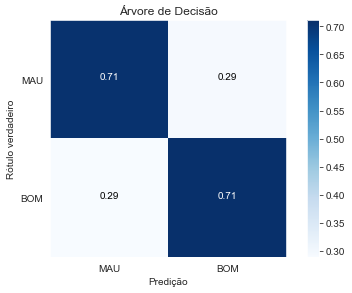

In [129]:
plot_confusion_matrix(confusion_matrix(y_test, previsoes_validacao),
                      classes=['MAU','BOM'] ,normalize = True, 
                      title='Árvore de Decisão')

## Random Forest

In [130]:
clf_rforest = RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=16)
clf_rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=16, n_estimators=250)

In [131]:
previsoes_treino = clf_rforest.predict(X_train)
previsoes_validacao = clf_rforest.predict(X_test)
rforest_roc = pd.DataFrame({'VR':y_test,'PROB':clf_rforest.predict_proba(X_test)[:,1]})
print('Acurácia do treino: ', clf_rforest.score(X_train,y_train))
print('Acurácia de validação: ', clf_rforest.score(X_test,y_test))

Acurácia do treino:  0.9111943719233911
Acurácia de validação:  0.907137874912811


In [132]:
print(classification_report(y_test, previsoes_validacao, target_names=['MAUS','BONS']))

              precision    recall  f1-score   support

        MAUS       0.92      0.89      0.91     10702
        BONS       0.90      0.92      0.91     10803

    accuracy                           0.91     21505
   macro avg       0.91      0.91      0.91     21505
weighted avg       0.91      0.91      0.91     21505



[[0.89366474 0.10633526]
 [0.07951495 0.92048505]]


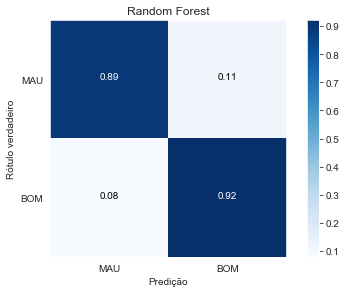

In [133]:
plot_confusion_matrix(confusion_matrix(y_test, previsoes_validacao),
                      classes=['MAU','BOM'] ,normalize = True, 
                      title='Random Forest')

## Comparação dos Modelos - Curva ROC

In [134]:
fpr, tpr, _ = roc_curve(reglog_roc.VR, reglog_roc['PROB'])
fpr2, tpr2, _ = roc_curve(tree_roc.VR, tree_roc['PROB'])
fpr3, tpr3, _ = roc_curve(rforest_roc.VR, rforest_roc['PROB'])
auc_reglog = roc_auc_score(y_test, reglog_roc['PROB'])
auc_tree = roc_auc_score(y_test, tree_roc['PROB'])
auc_rforest = roc_auc_score(y_test, rforest_roc['PROB'])

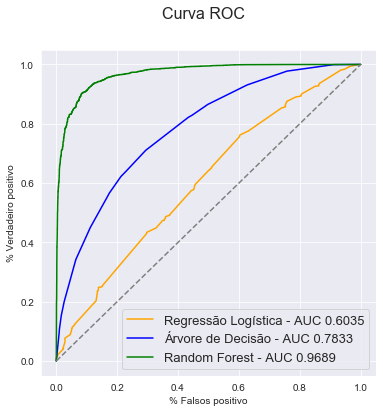

In [135]:
plt.figure(figsize=(6,6))
plt.suptitle('Curva ROC', size=16)
plt.plot(fpr, tpr, label=f'Regressão Logística - AUC {auc_reglog:.4}', color='orange')
plt.plot(fpr2, tpr2, label=f'Árvore de Decisão - AUC {auc_tree:.4}', color='blue')
plt.plot(fpr3, tpr3, label=f'Random Forest - AUC {auc_rforest:.4}', color='green')
plt.plot([0,1], [0,1], '--', color='grey')
plt.xlabel('% Falsos positivo')
plt.ylabel('% Verdadeiro positivo')
plt.legend(fontsize=13)

# Como poderemos usar o modelo final?

- Através da definição de um Scorecard.
- Execução do modelo em *batch* ou *serviço*.
- Utilizando os parâmetros do modelo para gerar procedures em SQL ou automações.
- Percepções para o negócio, criação de políticas e estratégias.

# Como podemos acompanhar a performance do modelo ao longo do tempo?

A depender do modelo utilizado:
- Métricas de Estabilidade por Safra
    - Population stability index (PSI)
    - Peso da Evidência (WoE)
- Métricas de Performance por Safra.
    - Kolmogorov-smirnov (KS2)
    - Information value (IV)
- RAG Rating